# Simplest Possible Diffusion - No Time Embedding!

Let's strip it down to the absolute basics:
- ✅ Simple Conv autoencoder (like VAE encoder/decoder)
- ✅ NO time embedding - same network for all timesteps
- ✅ Just learn: noisy image → predicted noise

**Why this works:**
The network can still implicitly learn different noise levels from the data distribution.

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from realistica import NoiseScheduler, TinyConvDenoiser

## Config

In [12]:
# Training control
LOAD_MODEL = True  # Set to False to train from scratch

device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Device: {device}")

config = {
    'batch_size': 128,
    'num_epochs': 50,
    'lr': 1e-3,
    'num_timesteps': 1000,
    'checkpoint_path': 'outputs/mnist_conv_simple/checkpoint.pt',
}

os.makedirs('outputs/mnist_conv_simple/samples', exist_ok=True)
os.makedirs('outputs/mnist_conv_simple', exist_ok=True)

Device: mps


## Load Data

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

print(f"Dataset: {len(train_dataset)} images")

Dataset: 60000 images


## Model - Super Simple!

In [14]:
# Noise scheduler
noise_scheduler = NoiseScheduler(
    num_timesteps=config['num_timesteps'],
    beta_start=0.0001,
    beta_end=0.02,
    schedule_type='linear',
    device=device
)

# Tiny conv model - NO time embedding!
model = TinyConvDenoiser().to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {num_params:,}")

# Load checkpoint if exists and LOAD_MODEL is True
if LOAD_MODEL and os.path.exists(config['checkpoint_path']):
    print(f"Loading model from {config['checkpoint_path']}")
    checkpoint = torch.load(config['checkpoint_path'], map_location=device)
    
    # Handle both old format (nested dict) and new format (direct state_dict)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from epoch {checkpoint.get('epoch', 'unknown')}")
    else:
        model.load_state_dict(checkpoint)
        print("Model loaded!")
else:
    print("Training from scratch")

print(f"\nArchitecture:")
print(model)

Parameters: 82,945
Loading model from outputs/mnist_conv_simple/checkpoint.pt
Model loaded!

Architecture:
TinyConvDenoiser(
  (down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (down2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (up2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (up1): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


## Training - Dead Simple

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.MSELoss()

losses = []

for epoch in range(config['num_epochs']):
    model.train()
    epoch_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")
    for images, _ in pbar:
        images = images.to(device)
        batch_size = images.shape[0]
        
        # Random timesteps
        t = noise_scheduler.sample_timesteps(batch_size)
        
        # Add noise
        noisy_images, noise = noise_scheduler.add_noise(images, t)
        
        # Predict noise (NO time input!)
        pred_noise = model(noisy_images)
        
        # Loss
        loss = criterion(pred_noise, noise)
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.6f}")

# Save model
print(f"\nSaving model to {config['checkpoint_path']}")
torch.save(model.state_dict(), config['checkpoint_path'])
print("Done!")

Epoch 1/50: 100%|██████████| 469/469 [00:06<00:00, 68.57it/s, loss=0.0454] 


Epoch 1 - Avg Loss: 0.050284


Epoch 2/50: 100%|██████████| 469/469 [00:06<00:00, 73.09it/s, loss=0.0445] 


Epoch 2 - Avg Loss: 0.042441


Epoch 3/50: 100%|██████████| 469/469 [00:06<00:00, 73.72it/s, loss=0.0469] 


Epoch 3 - Avg Loss: 0.043267


Epoch 4/50: 100%|██████████| 469/469 [00:06<00:00, 74.19it/s, loss=0.0405] 


Epoch 4 - Avg Loss: 0.042980


Epoch 5/50: 100%|██████████| 469/469 [00:06<00:00, 74.46it/s, loss=0.0479] 


Epoch 5 - Avg Loss: 0.042822


Epoch 6/50: 100%|██████████| 469/469 [00:06<00:00, 71.85it/s, loss=0.0375] 


Epoch 6 - Avg Loss: 0.043174


Epoch 7/50: 100%|██████████| 469/469 [00:07<00:00, 59.01it/s, loss=0.0384]


Epoch 7 - Avg Loss: 0.042794


Epoch 8/50: 100%|██████████| 469/469 [00:07<00:00, 59.65it/s, loss=0.0386]


Epoch 8 - Avg Loss: 0.042955


Epoch 9/50: 100%|██████████| 469/469 [00:07<00:00, 60.03it/s, loss=0.0474]


Epoch 9 - Avg Loss: 0.042845


Epoch 10/50: 100%|██████████| 469/469 [00:07<00:00, 60.86it/s, loss=0.0455]


Epoch 10 - Avg Loss: 0.042562


Epoch 11/50: 100%|██████████| 469/469 [00:07<00:00, 59.63it/s, loss=0.0446]


Epoch 11 - Avg Loss: 0.042619


Epoch 12/50: 100%|██████████| 469/469 [00:07<00:00, 60.01it/s, loss=0.0445]


Epoch 12 - Avg Loss: 0.042660


Epoch 13/50: 100%|██████████| 469/469 [00:07<00:00, 61.16it/s, loss=0.0447]


Epoch 13 - Avg Loss: 0.042873


Epoch 14/50: 100%|██████████| 469/469 [00:07<00:00, 59.68it/s, loss=0.0413]


Epoch 14 - Avg Loss: 0.043099


Epoch 15/50: 100%|██████████| 469/469 [00:07<00:00, 59.87it/s, loss=0.0384]


Epoch 15 - Avg Loss: 0.042664


Epoch 16/50: 100%|██████████| 469/469 [00:07<00:00, 61.71it/s, loss=0.0430]


Epoch 16 - Avg Loss: 0.042516


Epoch 17/50: 100%|██████████| 469/469 [00:07<00:00, 59.34it/s, loss=0.0347]


Epoch 17 - Avg Loss: 0.042439


Epoch 18/50: 100%|██████████| 469/469 [00:07<00:00, 60.16it/s, loss=0.0407]


Epoch 18 - Avg Loss: 0.042434


Epoch 19/50: 100%|██████████| 469/469 [00:07<00:00, 59.28it/s, loss=0.0366]


Epoch 19 - Avg Loss: 0.042288


Epoch 20/50: 100%|██████████| 469/469 [00:07<00:00, 60.25it/s, loss=0.0469]


Epoch 20 - Avg Loss: 0.042177


Epoch 21/50: 100%|██████████| 469/469 [00:07<00:00, 60.23it/s, loss=0.0423]


Epoch 21 - Avg Loss: 0.042427


Epoch 22/50: 100%|██████████| 469/469 [00:07<00:00, 60.04it/s, loss=0.0417]


Epoch 22 - Avg Loss: 0.042297


Epoch 23/50: 100%|██████████| 469/469 [00:07<00:00, 60.70it/s, loss=0.0473]


Epoch 23 - Avg Loss: 0.042194


Epoch 24/50: 100%|██████████| 469/469 [00:07<00:00, 60.19it/s, loss=0.0374]


Epoch 24 - Avg Loss: 0.042510


Epoch 25/50: 100%|██████████| 469/469 [00:08<00:00, 58.53it/s, loss=0.0493]


Epoch 25 - Avg Loss: 0.042145


Epoch 26/50: 100%|██████████| 469/469 [00:07<00:00, 60.37it/s, loss=0.0353]


Epoch 26 - Avg Loss: 0.041999


Epoch 27/50: 100%|██████████| 469/469 [00:07<00:00, 59.73it/s, loss=0.0419]


Epoch 27 - Avg Loss: 0.042610


Epoch 28/50: 100%|██████████| 469/469 [00:07<00:00, 59.71it/s, loss=0.0385]


Epoch 28 - Avg Loss: 0.042076


Epoch 29/50: 100%|██████████| 469/469 [00:07<00:00, 61.26it/s, loss=0.0445]


Epoch 29 - Avg Loss: 0.041902


Epoch 30/50: 100%|██████████| 469/469 [00:07<00:00, 60.06it/s, loss=0.0391]


Epoch 30 - Avg Loss: 0.042047


Epoch 31/50: 100%|██████████| 469/469 [00:07<00:00, 60.04it/s, loss=0.0443]


Epoch 31 - Avg Loss: 0.042317


Epoch 32/50: 100%|██████████| 469/469 [00:07<00:00, 60.43it/s, loss=0.0460]


Epoch 32 - Avg Loss: 0.041846


Epoch 33/50: 100%|██████████| 469/469 [00:07<00:00, 59.03it/s, loss=0.0430]


Epoch 33 - Avg Loss: 0.041719


Epoch 34/50: 100%|██████████| 469/469 [00:07<00:00, 59.55it/s, loss=0.0359]


Epoch 34 - Avg Loss: 0.041961


Epoch 35/50: 100%|██████████| 469/469 [00:07<00:00, 59.59it/s, loss=0.0467]


Epoch 35 - Avg Loss: 0.041995


Epoch 36/50: 100%|██████████| 469/469 [00:07<00:00, 59.88it/s, loss=0.0472]


Epoch 36 - Avg Loss: 0.042003


Epoch 37/50: 100%|██████████| 469/469 [00:07<00:00, 59.95it/s, loss=0.0450]


Epoch 37 - Avg Loss: 0.041850


Epoch 38/50: 100%|██████████| 469/469 [00:07<00:00, 60.15it/s, loss=0.0390]


Epoch 38 - Avg Loss: 0.041811


Epoch 39/50: 100%|██████████| 469/469 [00:07<00:00, 61.88it/s, loss=0.0421]


Epoch 39 - Avg Loss: 0.041838


Epoch 40/50: 100%|██████████| 469/469 [00:08<00:00, 58.12it/s, loss=0.0457]


Epoch 40 - Avg Loss: 0.041582


Epoch 41/50: 100%|██████████| 469/469 [00:07<00:00, 58.92it/s, loss=0.0488]


Epoch 41 - Avg Loss: 0.041851


Epoch 42/50: 100%|██████████| 469/469 [00:07<00:00, 60.02it/s, loss=0.0356]


Epoch 42 - Avg Loss: 0.041275


Epoch 43/50: 100%|██████████| 469/469 [00:07<00:00, 59.83it/s, loss=0.0399]


Epoch 43 - Avg Loss: 0.041449


Epoch 44/50: 100%|██████████| 469/469 [00:08<00:00, 57.76it/s, loss=0.0422]


Epoch 44 - Avg Loss: 0.041632


Epoch 45/50: 100%|██████████| 469/469 [00:07<00:00, 61.27it/s, loss=0.0351]


Epoch 45 - Avg Loss: 0.041760


Epoch 46/50: 100%|██████████| 469/469 [00:07<00:00, 59.70it/s, loss=0.0484]


Epoch 46 - Avg Loss: 0.041231


Epoch 47/50: 100%|██████████| 469/469 [00:07<00:00, 60.21it/s, loss=0.0465]


Epoch 47 - Avg Loss: 0.041611


Epoch 48/50: 100%|██████████| 469/469 [00:08<00:00, 56.14it/s, loss=0.0444]


Epoch 48 - Avg Loss: 0.041399


Epoch 49/50: 100%|██████████| 469/469 [00:07<00:00, 60.67it/s, loss=0.0403]


Epoch 49 - Avg Loss: 0.041268


Epoch 50/50: 100%|██████████| 469/469 [00:07<00:00, 59.99it/s, loss=0.0350]

Epoch 50 - Avg Loss: 0.041545

Saving model to outputs/mnist_conv_simple/checkpoint.pt
Done!


## Sample

Sampling: 1000it [00:02, 417.68it/s]


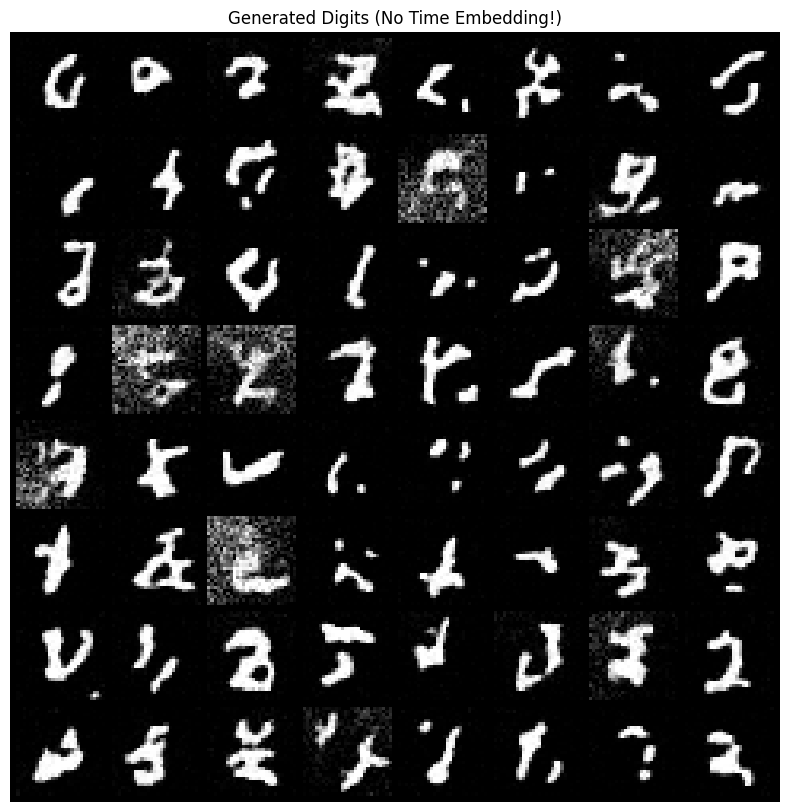

In [16]:
@torch.no_grad()
def sample(num_samples=64):
    model.eval()
    
    # Start from noise
    x = torch.randn(num_samples, 1, 28, 28, device=device)
    
    # Denoise
    for t in tqdm(reversed(range(config['num_timesteps'])), desc='Sampling'):
        t_batch = torch.tensor([t] * num_samples, device=device)
        
        # Predict noise (model ignores t)
        pred_noise = model(x)
        
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        
        # DDPM step
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * pred_noise)
        x = x + torch.sqrt(beta) * noise
    
    return x

# Generate
samples = sample(64)

# Show
grid = make_grid(samples, nrow=8, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Generated Digits (No Time Embedding!)')
plt.savefig('outputs/mnist_conv_simple/samples/generated.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualize Denoising

100%|██████████| 1000/1000 [00:00<00:00, 1396.20it/s]


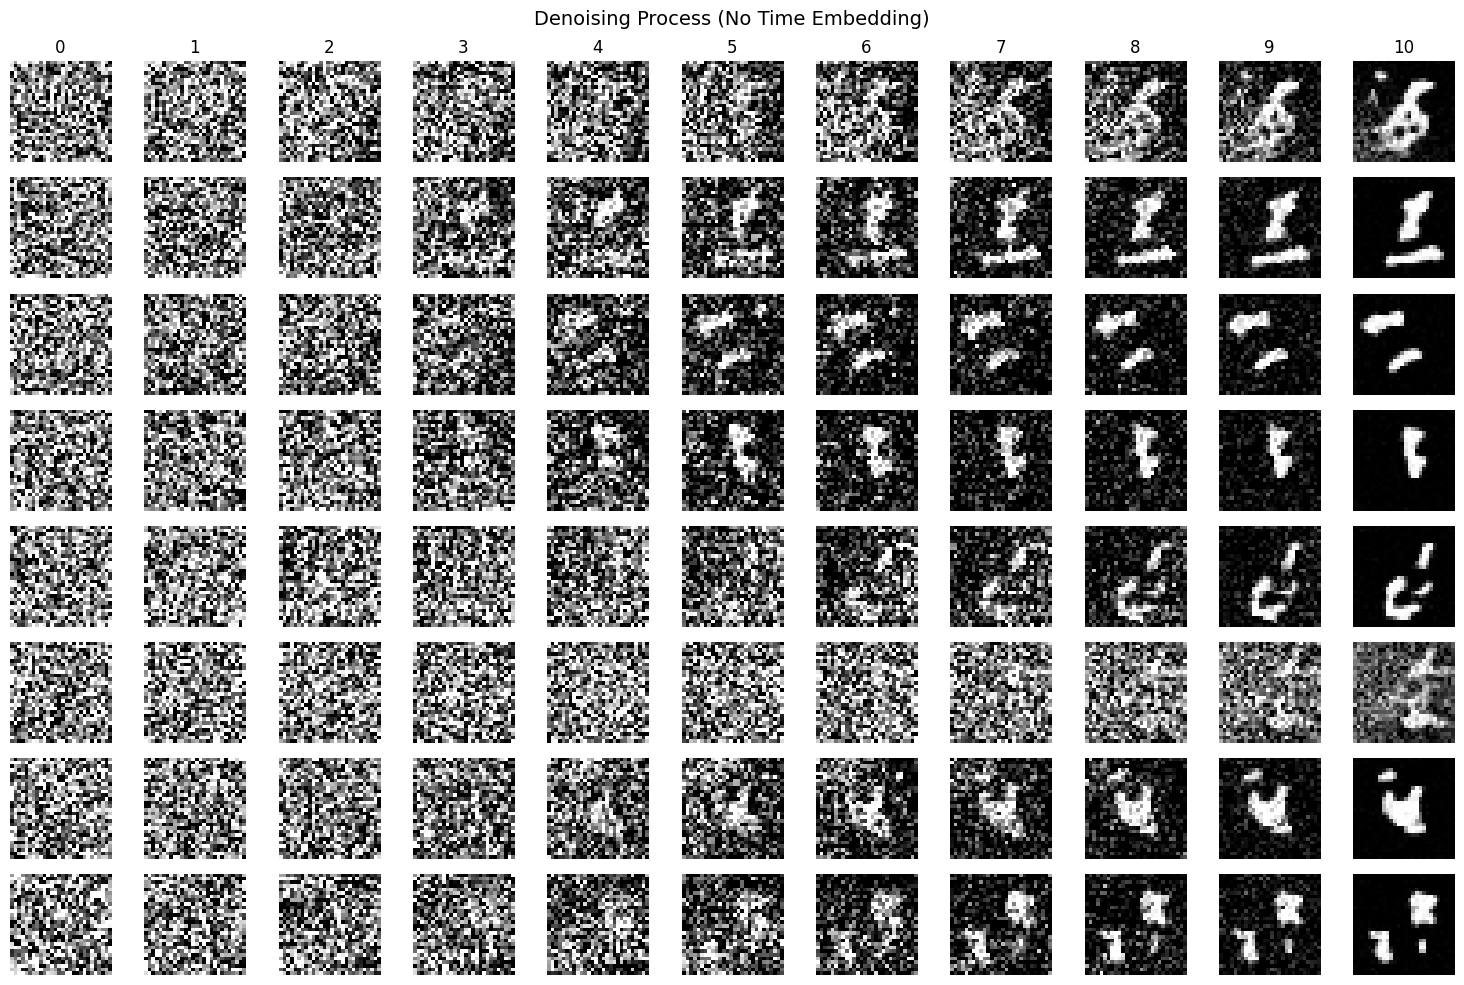

In [17]:
@torch.no_grad()
def sample_steps(num_samples=8, steps_to_show=10):
    model.eval()
    x = torch.randn(num_samples, 1, 28, 28, device=device)
    
    timesteps = list(reversed(range(config['num_timesteps'])))
    interval = len(timesteps) // steps_to_show
    saved = []
    
    for i, t in enumerate(tqdm(timesteps)):
        if i % interval == 0 or i == len(timesteps) - 1:
            saved.append(x.cpu().clone())
        
        pred_noise = model(x)
        
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        
        x = (1 / torch.sqrt(alpha)) * (x - (beta / torch.sqrt(1 - alpha_cumprod)) * pred_noise)
        x = x + torch.sqrt(beta) * noise
    
    return saved

steps = sample_steps(8, 10)

# Plot
fig, axes = plt.subplots(8, len(steps), figsize=(15, 10))
for i in range(8):
    for j, imgs in enumerate(steps):
        axes[i, j].imshow(imgs[i, 0].numpy(), cmap='gray', vmin=-1, vmax=1)
        axes[i, j].axis('off')
        if i == 0:
            axes[i, j].set_title(f'{j}')

plt.suptitle('Denoising Process (No Time Embedding)', fontsize=14)
plt.tight_layout()
plt.show()

## Does it work?

**Expected:**
- Model has only ~50K parameters
- No time conditioning at all
- Should still produce digit-like shapes
- Quality won't be amazing, but proves the concept

**If you see digits:** ✅ Your diffusion setup works!

**If you see maze patterns:** Try:
1. More epochs (30-50)
2. Lower learning rate (1e-4)
3. Check data normalization is [-1, 1]

**Next step:** Add time embedding for better quality